# SVD - Descomposición en valores singulares

La SVD (Singular Value Decomposition) es una técnica del álgebra lineal que descompone cualquier matriz $A \in \mathbb{R}^{m \times n}$ en tres componentes:

$$A = U \Sigma V^T$$

donde:
- $U$: matriz de vectores singulares izquierdos (representa las direcciones principales de las filas).
- $\Sigma$: matriz diagonal de valores singulares ($\sigma_i$), que indican la “fuerza” o “importancia” de cada dimensión latente.
- $V$: matriz de vectores singulares derechos (direcciones principales de las columnas).

Estos valores singulares ordenan las dimensiones de mayor a menor importancia, permitiendo representar la estructura de los datos en un espacio reducido.

**Algunas aplicaciones:**

- Reducción de dimensionalidad: como base de PCA para eliminar redundancia en los datos.
- Compresión y denoising: reducción de ruido en imágenes o señales.
- Sistemas de recomendación: extracción de factores latentes usuario–ítem (FunkSVD, SVD++).
- Etc..

**Motivación de utiliza este algoritmo:**

La motivación de usar SVD es revelar la estructura esencial oculta en los datos.
Al descomponer una matriz en tres partes $A = U \Sigma V^$T, SVD:
- Separa la información (patrones importantes) del ruido.
- Reduce dimensionalidad, manteniendo solo las relaciones más fuertes.
- Permite representar datos complejos (como usuarios e ítems) en un espacio latente compacto y útil para predicción o interpretación.

### Dato curioso:

PCA = SVD aplicado a la matriz de datos centrada.

- SVD descompone la matriz de datos directamente, sin asumir simetría.
- PCA busca rotar los ejes para maximizar la varianza (autovalores), pero internamente hace lo mismo que SVD sobre la matriz centrada.

## Aplicación en sistemas de recomendación

En sistemas de recomendación, la SVD (Descomposición en Valores Singulares) se utiliza para factorizar la matriz de interacciones usuario–ítem (por ejemplo, de ratings).
El objetivo es representar tanto a los usuarios como a los ítems en un espacio latente compartido, donde las relaciones se modelan a través de unos pocos factores latentes.

Existen dos enfoques principales adaptados a este contexto:
1.	SVD truncada:
En lugar de reconstruir la matriz original de manera exacta, se aproxima utilizando solo los k valores singulares más importantes.
Esto reduce la dimensionalidad y preserva las relaciones más relevantes entre usuarios e ítems.

2.	SVD ajustada sobre valores conocidos (FunkSVD, SVD++):
En este enfoque, no se aplica la SVD algebraica clásica, sino que se entrenan matrices latentes $U$ y $V$ (que absorben implícitamente a $\Sigma$) mediante un proceso iterativo que minimiza el error sobre los ratings observados.
Por ejemplo, si el usuario 1 calificó con 4 el ítem 3, y el usuario 4 calificó con 1 el ítem 5, el algoritmo ajusta los vectores correspondientes $U_1, V_3, U_4, V_5$ para que el producto punto $U_u \cdot V_i^T$ se aproxime lo más posible a las calificaciones reales.

$$R \approx U_k \Sigma_k V_k^T$$

donde k es el número de factores latentes.
Cada usuario e ítem se representa en el espacio latente como:

$$P = U_k \Sigma_k^{1/2}, \quad Q = V_k \Sigma_k^{1/2}$$

y la predicción de un rating se obtiene mediante:

$$\hat{r}_{ui} = P_u \cdot Q_i^T$$

### Importación de librerías

In [7]:
# !pip install cmfrec
# !pip install lightfm
# !pip install matrix-factorization

In [8]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [9]:
from numpy.linalg import svd

### Lectura del conjunto de datos

En este ejemplo estaremos trabajando con el dataset [IMDB](https://ai.stanford.edu/~amaas/data/sentiment/)

In [10]:
ruta_archivo = 'u.data'

In [11]:
df = pd.read_csv(ruta_archivo, sep='\t', names=['user_id','movie_id','rating','timestamp'])
df

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


### 1️⃣ SVD tradicional
- Definición: $A = U \Sigma V^T$
- Valores singulares ($\sigma_i$): importancia de cada componente / varianza explicada
- Uso: PCA, compresión, análisis espectral
- Requisito: matriz completa


In [12]:
# from numpy.linalg import svd

El método `svd` de NumPy requiere una matriz de interacciones, por lo que convertimos los datos al formato [usuarios × ítems] con los ratings como valores.

In [ ]:
# Convertir el DataFrame de ratings a una matriz de usuarios × ítems,
# donde las filas son usuarios, las columnas son películas y los valores son los ratings.
ratings_df = pd.pivot_table(data=df, values='rating', index='user_id', columns='movie_id')

Para acelerar los calculos, podemos guardar los valores de esta matriz de iteraaciones en formato array de NumPy:

In [14]:
# ratings_df: DataFrame donde filas=usuarios, columnas=películas, valores=ratings
A = ratings_df.values  # forma (m, n), sin valores faltantes

In [15]:
# SVD completa
U, s, VT = svd(A, full_matrices=False)

LinAlgError: SVD did not converge

Como la mayoria de transformadores o estimadores, como `SVD` tradicional opera sobre todo el dataset y no solo sobre los valores conocidos, tenemos el problema de valores nulos.. Imputaremos por '0' para simplificar

In [16]:
# Reemplazar NaN por 0 (u otra estrategia, como la media del usuario)
A = np.nan_to_num(A, nan=0.0)  # reemplaza NaN por 0

In [17]:
# SVD completa
U, s, VT = svd(A, full_matrices=False)
U.shape, s.shape, VT.shape

((943, 943), (943,), (943, 1682))

Vemos que $s$ tiene forma de vector unidimensional, ya que contiene únicamente los valores singulares.
Sin embargo, para poder realizar la reconstrucción matricial completa, necesitamos convertirlo en una matriz diagonal $Σ$, donde los elementos de $s$ se ubiquen en la diagonal principal.
Esta matriz debe tener tantas filas como $U$ y tantas columnas como $V^T$, de modo que las dimensiones sean compatibles en la multiplicación:

$A \approx U \, \Sigma \, V^T$

In [ ]:
# Convertir el vector de valores singulares 's' en una matriz diagonal Σ
# para poder usarla en la reconstrucción de la matriz original.
Sigma = np.diag(s)
Sigma.shape  # Mostrar las dimensiones de la matriz diagonal

(943, 943)

Podemos cuantificar la importancia de cada vector singular (en U y V^T) usando la matriz Σ, que contiene los valores singulares asociados a cada componente.

In [ ]:
# Vector de valores singulares obtenido de la SVD,
# que indica la "energía" o importancia de cada componente latente.
s

array([640.63362257, 244.83634567, 217.84622472, 159.15359872,
       158.21191449, 145.87261327, 126.57977314, 121.90769976,
       106.8291837 ,  99.74793974,  93.79885965,  93.25844284,
        89.91150168,  84.34178722,  83.81220836,  81.81204105,
        79.07796788,  77.88652669,  76.387996  ,  75.3415951 ,
        73.68235502,  72.80837191,  72.51350545,  71.52749477,
        69.77179735,  69.10881715,  68.8735702 ,  67.94277928,
        67.40829434,  67.06352378,  66.85757418,  65.59270059,
        65.27526042,  64.79965625,  64.44727664,  64.09819141,
        63.91638042,  63.08261122,  62.67586971,  62.23742793,
        62.03574728,  61.77291401,  61.33544177,  61.0632462 ,
        60.56817026,  60.30813928,  59.77166759,  59.51420996,
        59.40675   ,  59.10683763,  58.83667955,  58.53445585,
        58.33802154,  58.1323194 ,  57.41759146,  57.36384311,
        57.30977341,  56.99448748,  56.72636608,  56.239748  ,
        56.17894513,  55.8734678 ,  55.65459359,  55.52

In [ ]:
# Suma de todos los valores singulares,
# útil para medir la varianza total o la energía total capturada por la matriz.
sum(s)

np.float64(21976.89554838)

In [ ]:
# Calcular el porcentaje de varianza explicada por cada valor singular,
# mostrando qué tanto contribuye cada componente latente a la estructura total de la matriz.
s / sum(s) * 100

array([2.91503239, 1.11406247, 0.99125113, 0.72418599, 0.71990111,
       0.66375441, 0.57596749, 0.55470846, 0.4860977 , 0.45387639,
       0.42680669, 0.42434766, 0.4091183 , 0.3837748 , 0.38136509,
       0.37226387, 0.3598232 , 0.35440186, 0.3475832 , 0.34282183,
       0.3352719 , 0.33129507, 0.32995336, 0.32546678, 0.31747795,
       0.31446123, 0.31339081, 0.30915549, 0.30672346, 0.30515467,
       0.30421755, 0.29846208, 0.29701766, 0.29485355, 0.29325014,
       0.29166172, 0.29083444, 0.28704059, 0.28518982, 0.28319481,
       0.28227712, 0.28108116, 0.27909056, 0.27785201, 0.2755993 ,
       0.2744161 , 0.27197503, 0.27080353, 0.27031457, 0.2689499 ,
       0.26772061, 0.26634542, 0.2654516 , 0.26451561, 0.26126343,
       0.26101886, 0.26077283, 0.25933821, 0.25811819, 0.25590397,
       0.2556273 , 0.25423731, 0.25324138, 0.25266565, 0.25223654,
       0.25151695, 0.2509248 , 0.25019416, 0.24858892, 0.24776901,
       0.24703243, 0.24576788, 0.24421491, 0.24315531, 0.24247

In [ ]:
# Verificar que la suma de los porcentajes de varianza explicada sea 100%,
# confirmando que todos los componentes considerados cubren la totalidad de la varianza.
sum(s / sum(s) * 100)

np.float64(100.00000000000007)

Como vimos, la `SVD` puede emplearse para diversos fines (reducción de dimensionalidad, sistemas de recomendación, compresión de datos, etc.).
Una de sus aplicaciones más directas es la reconstrucción de la matriz original a partir de sus componentes.

Podemos optar por dos enfoques:
- Reconstrucción exacta, utilizando todos los vectores y valores singulares.
- Reconstrucción aproximada, empleando solo los k valores singulares más grandes, lo que reduce el costo computacional y, en muchos casos, elimina ruido asociado a dimensiones menos relevantes.

En este caso, al tratarse de una `SVD` tradicional (no truncada), realizaremos una reconstrucción exacta de la matriz original:

In [27]:
# Reconstrucción exacta
A_hat = U @ Sigma @ VT
A_hat

array([[ 5.00000000e+00,  3.00000000e+00,  4.00000000e+00, ...,
        -5.36680075e-17, -1.31080043e-16, -6.27969898e-16],
       [ 4.00000000e+00, -8.09848716e-13,  2.54102295e-14, ...,
         1.14491749e-15, -3.67761377e-16, -1.25290403e-15],
       [ 5.01508557e-15,  1.92554306e-15,  6.02799061e-14, ...,
        -2.42861287e-17,  1.23165367e-15,  3.81639165e-16],
       ...,
       [ 5.00000000e+00,  5.95357097e-15,  2.28289609e-15, ...,
         1.03042574e-15,  5.75928194e-16, -1.25767452e-17],
       [ 1.27745037e-14, -1.75554016e-14,  1.60722130e-15, ...,
         6.39245601e-16, -1.01915004e-16, -6.79577922e-16],
       [ 2.65482081e-14,  5.00000000e+00, -1.14231541e-15, ...,
        -1.17917828e-15, -2.38307638e-16,  3.35668993e-16]],
      shape=(943, 1682))

Al utilizar todos los vectores singulares de $U$ y $V_T$ y todos los valores sigulates de la matriz diagonal, la reconstrucción es exacta a la matriz original, no es una aproximación.

In [ ]:
# Comparar los primeros 10×10 elementos de la matriz reconstruida A_hat
# con la matriz original A para ver la aproximación obtenida mediante SVD.
A_hat[:10, :10], A[:10, :10]  # Mostrar fragmentos para inspección visual

(array([[ 5.00000000e+00,  3.00000000e+00,  4.00000000e+00,
          3.00000000e+00,  3.00000000e+00,  5.00000000e+00,
          4.00000000e+00,  1.00000000e+00,  5.00000000e+00,
          3.00000000e+00],
        [ 4.00000000e+00, -8.09848716e-13,  2.54102295e-14,
         -2.72564089e-14,  2.65065747e-15,  7.36711039e-14,
         -1.31636889e-13,  3.03594701e-14, -5.68889554e-14,
          2.00000000e+00],
        [ 5.01508557e-15,  1.92554306e-15,  6.02799061e-14,
         -1.25108257e-14, -5.48519563e-15, -4.39231984e-15,
          2.06707684e-14, -1.12635595e-14, -3.20401529e-14,
          2.43294968e-14],
        [ 7.17134685e-15,  4.79477569e-15, -9.94863913e-16,
          1.44264808e-13, -3.84132830e-14,  4.11823353e-15,
         -3.92220978e-15, -7.01825750e-15,  1.81278603e-16,
         -3.06065936e-14],
        [ 4.00000000e+00,  3.00000000e+00,  4.14546869e-14,
         -5.83361484e-14,  2.60745635e-13,  7.19782307e-14,
          5.50589305e-14, -2.06799096e-14,  2.666985

### 2️⃣ SVD truncada para recomendación
- Definición: $A \approx U_k \Sigma_k V_k^T$
- Valores singulares: fuerza de factores latentes (patrones usuario–ítem)
- Uso: predicción de ratings, embeddings de usuarios e ítems ya que ahora estan en la mismo numero de dimensiones `k`
- Requisito: matriz completa o con estrategias de imputación para valores faltantes
- Ventaja: reduce dimensionalidad, captura patrones latentes
- Nota: no maneja sparsidad de manera nativa; requiere completitud o aproximación



In [ ]:
# Convertir el DataFrame original a una matriz de usuarios × ítems,
# donde cada fila es un usuario, cada columna es una película y los valores son los ratings.
ratings_df = pd.pivot_table(data=df, values='rating', index='user_id', columns='movie_id')

In [30]:
# ratings_df: DataFrame donde filas=usuarios, columnas=películas, valores=ratings
A = ratings_df.values  # forma (m, n), sin valores faltantes

In [31]:
# SVD completa
U, s, VT = svd(A, full_matrices=False)
Sigma = np.diag(s)

LinAlgError: SVD did not converge

problema de valores nulos.. Imputaremos por '0' para simplificar

In [32]:
# Reemplazar NaN por 0 (u otra estrategia, como la media del usuario)
A = np.nan_to_num(A, nan=0.0)  # reemplaza NaN por 0

In [33]:
# SVD completa
U, s, VT = svd(A, full_matrices=False)
U.shape, s.shape, VT.shape

((943, 943), (943,), (943, 1682))

Vemos que $s$ tiene forma de vector unidimensional, ya que contiene únicamente los valores singulares.
Sin embargo, para poder realizar la reconstrucción matricial completa, necesitamos convertirlo en una matriz diagonal $Σ$, donde los elementos de $s$ se ubiquen en la diagonal principal.
Esta matriz debe tener tantas filas como $U$ y tantas columnas como $V^T$, de modo que las dimensiones sean compatibles en la multiplicación:

$A \approx U \, \Sigma \, V^T$

In [ ]:
# Convertir el vector de valores singulares 's' en una matriz diagonal Σ,
# para poder usarla en la reconstrucción de la matriz original.
Sigma = np.diag(s)
Sigma.shape  # Mostrar las dimensiones de la matriz diagonal

(943, 943)

Podemos cuantificar la importancia de cada vector singular (en U y V^T) usando la matriz Σ, que contiene los valores singulares asociados a cada componente.

In [ ]:
# Vector de valores singulares obtenido de la SVD,
# que indica la importancia relativa o "energía" de cada componente latente.
s

array([640.63362257, 244.83634567, 217.84622472, 159.15359872,
       158.21191449, 145.87261327, 126.57977314, 121.90769976,
       106.8291837 ,  99.74793974,  93.79885965,  93.25844284,
        89.91150168,  84.34178722,  83.81220836,  81.81204105,
        79.07796788,  77.88652669,  76.387996  ,  75.3415951 ,
        73.68235502,  72.80837191,  72.51350545,  71.52749477,
        69.77179735,  69.10881715,  68.8735702 ,  67.94277928,
        67.40829434,  67.06352378,  66.85757418,  65.59270059,
        65.27526042,  64.79965625,  64.44727664,  64.09819141,
        63.91638042,  63.08261122,  62.67586971,  62.23742793,
        62.03574728,  61.77291401,  61.33544177,  61.0632462 ,
        60.56817026,  60.30813928,  59.77166759,  59.51420996,
        59.40675   ,  59.10683763,  58.83667955,  58.53445585,
        58.33802154,  58.1323194 ,  57.41759146,  57.36384311,
        57.30977341,  56.99448748,  56.72636608,  56.239748  ,
        56.17894513,  55.8734678 ,  55.65459359,  55.52

In [ ]:
# Suma de todos los valores singulares,
# útil para medir la varianza total o la energía total capturada por la matriz.
sum(s)

np.float64(21976.89554838)

In [38]:
# Calcula el porcentaje de varianza explicada por cada valor singular
s / sum(s) * 100

NameError: name 'S' is not defined

In [ ]:
# Verificar que la suma de los porcentajes de varianza explicada sea 100%,
# confirmando que todos los componentes considerados cubren la totalidad de la varianza.
sum(s / sum(s) * 100)

np.float64(100.00000000000007)

In [ ]:
# Definir el número de factores latentes o componentes principales a usar
# en la SVD truncada. Aquí se seleccionan los k=10 más importantes.
k = 10

La SVD se puede usar para reducción de dimensionalidad, recomendación, compresión de datos, etc. 
Una aplicación clave es reconstruir la matriz original a partir de sus componentes.

En este caso, al tratarse de una `SVD` trunkado, realizaremos una reconstrucción aproximada (no exacta) de la matriz original utilizando solo k componentes:

In [ ]:
# Seleccionar los primeros k vectores y valores singulares para la SVD truncada
# U_k: primeros k vectores singulares izquierdos
# Sigma_k: primeros k valores singulares como matriz diagonal
# V_k: primeros k vectores singulares derechos

U_k = U[:, :k]
Sigma_k = np.diag(s[:k])
V_k = VT.T[:, :k]

In [72]:
# Reconstrucción aproximada de la matriz original usando solo los k factores latentes
# Esta aproximación reduce dimensionalidad y captura la mayor parte de la información relevante
A_hat = U_k @ Sigma_k @ V_k.T
A_hat

array([[ 4.01688618e+00,  2.10514989e+00,  1.37439578e+00, ...,
        -3.83174025e-03,  2.64379479e-02,  7.33806834e-02],
       [ 1.99295186e+00, -1.81693234e-02, -4.30251308e-03, ...,
         9.28078660e-03, -2.66167393e-03, -2.95256660e-02],
       [-1.74774668e-01, -5.60278496e-02,  1.81311614e-01, ...,
         2.16443047e-02,  1.91721169e-03,  2.49374917e-04],
       ...,
       [ 2.23624102e+00,  3.89103327e-02,  2.76077652e-01, ...,
        -5.53764648e-03,  1.07306047e-02, -4.23773725e-03],
       [ 1.31024409e+00,  1.55156267e-01, -4.75132794e-01, ...,
         1.50293142e-02,  1.15206267e-02, -2.94522888e-02],
       [ 1.72204325e+00,  2.05335046e+00,  1.18288029e+00, ...,
        -9.89971558e-03,  1.73695571e-02,  2.05937102e-02]],
      shape=(943, 1682))

Al seleccionar solo los k valores y vectores singulares más importantes, obtenemos una aproximación de la matriz original con un costo computacional mucho menor.

In [73]:
# Comparar la matriz reconstruida A_hat con la matriz original A
# para evaluar visualmente la aproximación obtenida mediante la SVD truncada
A_hat, A

(array([[ 4.01688618e+00,  2.10514989e+00,  1.37439578e+00, ...,
         -3.83174025e-03,  2.64379479e-02,  7.33806834e-02],
        [ 1.99295186e+00, -1.81693234e-02, -4.30251308e-03, ...,
          9.28078660e-03, -2.66167393e-03, -2.95256660e-02],
        [-1.74774668e-01, -5.60278496e-02,  1.81311614e-01, ...,
          2.16443047e-02,  1.91721169e-03,  2.49374917e-04],
        ...,
        [ 2.23624102e+00,  3.89103327e-02,  2.76077652e-01, ...,
         -5.53764648e-03,  1.07306047e-02, -4.23773725e-03],
        [ 1.31024409e+00,  1.55156267e-01, -4.75132794e-01, ...,
          1.50293142e-02,  1.15206267e-02, -2.94522888e-02],
        [ 1.72204325e+00,  2.05335046e+00,  1.18288029e+00, ...,
         -9.89971558e-03,  1.73695571e-02,  2.05937102e-02]],
       shape=(943, 1682)),
 array([[4.01688618, 2.10514989, 1.37439578, ..., 0.        , 0.        ,
         0.        ],
        [1.99295186, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.

En este caso, además de aproximar los valores observados, imputamos únicamente los valores faltantes en una copia de la matriz original, dejando intactas las interacciones conocidas.

In [ ]:
# Mantener los valores originales en la reconstrucción solo donde existen datos observados en A

A_not_nan = A > 0 # mascara booleana que indica posiciones donde habia interacciones en la matriz original
A_hat[A_not_nan] = A[A_not_nan] # imputado de interacciones originales en la matriz de interacciones aproximada
A_hat

array([[ 4.01688618e+00,  2.10514989e+00,  1.37439578e+00, ...,
        -3.83174025e-03,  2.64379479e-02,  7.33806834e-02],
       [ 1.99295186e+00, -1.81693234e-02, -4.30251308e-03, ...,
         9.28078660e-03, -2.66167393e-03, -2.95256660e-02],
       [-1.74774668e-01, -5.60278496e-02,  1.81311614e-01, ...,
         2.16443047e-02,  1.91721169e-03,  2.49374917e-04],
       ...,
       [ 2.23624102e+00,  3.89103327e-02,  2.76077652e-01, ...,
        -5.53764648e-03,  1.07306047e-02, -4.23773725e-03],
       [ 1.31024409e+00,  1.55156267e-01, -4.75132794e-01, ...,
         1.50293142e-02,  1.15206267e-02, -2.94522888e-02],
       [ 1.72204325e+00,  2.05335046e+00,  1.18288029e+00, ...,
        -9.89971558e-03,  1.73695571e-02,  2.05937102e-02]],
      shape=(943, 1682))

Ahora los usuarios y los ítems están representados por k factores latentes, lo que permite ubicarlos en un mismo espacio latente.  En este espacio se pueden analizar similitudes, y si k = 2 o 3, incluso visualizarlos gráficamente. Se multiplica cada factor por la raíz cuadrada de $\sigma_k$ para equilibrar magnitudes

In [ ]:
# Crear embeddings de usuarios e ítems a partir de la SVD truncada

X_users = U_k @ np.sqrt(Sigma_k)
Y_items = V_k @ np.sqrt(Sigma_k)

In [ ]:
# import matplotlib.pyplot as plt

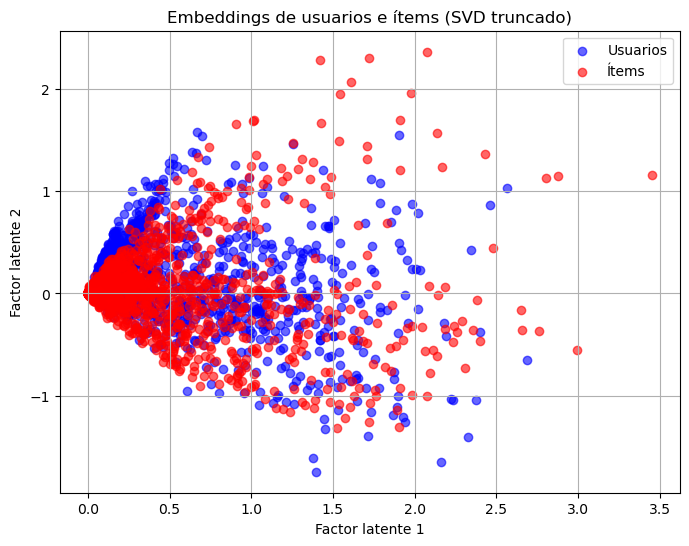

In [76]:
# Supongamos que k=2 para poder graficar
plt.figure(figsize=(8,6))

# Graficar embeddings de usuarios
plt.scatter(X_users[:,0], X_users[:,1], c='blue', alpha=0.6, label='Usuarios')

# Graficar embeddings de ítems
plt.scatter(Y_items[:,0], Y_items[:,1], c='red', alpha=0.6, label='Ítems')

plt.xlabel('Factor latente 1')
plt.ylabel('Factor latente 2')
plt.title('Embeddings de usuarios e ítems (SVD truncado)')
plt.legend()
plt.grid(True)
plt.show()

El gráfico muestra los embeddings de usuarios (azul) e ítems (rojo) en un espacio latente 2D obtenido con SVD truncado (k=2).
- Cada punto representa un usuario o ítem según sus factores latentes más importantes.
- La proximidad entre puntos indica similitud en preferencias o características latentes: usuarios cercanos tienden a tener gustos similares, y ítems cercanos tienden a ser percibidos como similares.

### 3️⃣ SVD iterativa (FunkSVD, SVD++) paso a paso:
- Definición: optimización iterativa
$\min_{P,Q} \sum_{(u,i) \in \Omega} (r_{ui} - p_u^T q_i)^2 + \lambda(\|p_u\|^2 + \|q_i\|^2)$
- Valores singulares: implícitos; $P$ y $Q$ se ajustan por gradiente o ALS
- Uso: recomendadores modernos, escalables, con regularización e interacciones implícitas
- Requisito: no necesita matriz completa; solo requiere los ratings observados
- Ventaja: funciona directamente con matrices muy dispersas y generaliza patrones latentes

Para optimizar el entrenamiento iterativo, se mapean los IDs de usuarios y películas a índices consecutivos (0 a n-1). 
Esto permite recorrer matrices de manera eficiente en los bucles de SGD:

In [46]:
# Crear diccionarios para mapear IDs originales a índices consecutivos
user_mapping = {id_: idx for idx, id_ in enumerate(df['user_id'].unique())}
item_mapping = {id_: idx for idx, id_ in enumerate(df['movie_id'].unique())}

In [47]:
# Agregar columnas con los índices mapeados
df['user_idx'] = df['user_id'].map(user_mapping)
df['item_idx'] = df['movie_id'].map(item_mapping)

Definimos el número de factores latentes 'k', que determina las dimensiones de las matrices P y Q y captura las relaciones entre usuarios e ítems. En este caso usamos k = 20.

In [ ]:
k = 20  # número de factores latentes

FunkSVD no utiliza la SVD tradicional para inicializar los factores. 
En su lugar, inicializa aleatoriamente los parámetros y los optimiza mediante SGD:

- Sesgos de usuarios e ítems: inicializados en 0 con la misma dimension correspondiente a usuarios e items respectivamente.
- Factores P y Q (equivalente a U y V^T, absorbiendo implícitamente Σ): inicialización aleatoria
- Media global: calculada como la media de todos los ratings observados. Se utiliza como referencia base en la predicción, de modo que los errores se centren en la desviación individual de cada usuario o ítem respecto a esta media, ayudando a estabilizar el aprendizaje y mejorar la convergencia.

In [ ]:
# Calcular número de usuarios e ítems
n_items = df['item_idx'].nunique()
n_users = df['user_idx'].nunique()

In [49]:
# Inicializar matrices de factores y vectores de sesgos
P = np.random.normal(scale=0.1, size=(n_users, k))
Q = np.random.normal(scale=0.1, size=(n_items, k))
bu = np.zeros(n_users)
bi = np.zeros(n_items)
global_mean = df['rating'].mean()

Como FunKSV utiliza SGD, además de los parámetros del modelo debemos definir los hiperparámetros que controlan el entrenamiento:

- Learning rate (lr): tasa de aprendizaje del SGD
- Regularización (lambda_reg): penaliza grandes valores en factores y sesgos para evitar sobreajuste
- Número de épocas (n_epochs): cantidad de iteraciones sobre todos los ratings observados

In [50]:
# Definir hiperparámetros del entrenamiento
lr = 0.005
lambda_reg = 0.02
n_epochs = 10

Para optimizar el entrenamiento iterativo, se extraen los IDs de usuarios, los IDs de películas y los ratings en tres vectores independientes. Esto permite recorrerlos de manera eficiente en los bucles de SGD.

In [51]:
# Extraer arrays de índices y ratings observados
rows = df['user_idx'].values
cols = df['item_idx'].values
vals = df['rating'].values

Entrenamiento del modelo mediante SGD, ajustando solo sobre los ratings conocidos para minimizar el error cuadrático.

El modelo actualiza:
- Factores latentes de usuarios (P)
- Factores latentes de ítems (Q)
- No necesitamos $\Sigma_k$ explícita; su efecto ya está absorbido en P y Q
- Sesgos de usuarios e ítems (bu, bi)

In [52]:
# Bucle principal de entrenamiento (SGD)
for epoch in range(n_epochs):
    
    for u, i, r_ui in zip(rows, cols, vals):
        
        # Calcular predicción actual
        pred = global_mean + bu[u] + bi[i] + P[u] @ Q[i].T
        
        # Calcular error de predicción
        err = r_ui - pred
        
        # Actualizar parámetros usando gradiente descendente
        bu[u] += lr * (err - lambda_reg * bu[u])
        bi[i] += lr * (err - lambda_reg * bi[i])
        P[u] += lr * (err * Q[i] - lambda_reg * P[u])
        Q[i] += lr * (err * P[u] - lambda_reg * Q[i])
    
    # Mostrar progreso por época
    print(f"Epoch {epoch+1} finalizada")

Epoch 1 finalizada
Epoch 2 finalizada
Epoch 3 finalizada
Epoch 4 finalizada
Epoch 5 finalizada
Epoch 6 finalizada
Epoch 7 finalizada
Epoch 8 finalizada
Epoch 9 finalizada
Epoch 10 finalizada


La SVD se puede usar para reducción de dimensionalidad, recomendación, compresión de datos, etc. 
Una aplicación clave es reconstruir la matriz original a partir de sus componentes.

En FunkSVD, usamos una versión truncada con los k factores latentes más importantes, lo que permite una reconstrucción aproximada (no exacta) de la matriz original usando solo k componentes.

- P: factores de usuarios (equivalente a U_k @ sqrt(Sigma_k))
- Q: factores de ítems (equivalente a V_k @ sqrt(Sigma_k))

In [ ]:
U_k = P  # factores de usuarios aprendidos
V_k = Q  # factores de ítems aprendidos
# Sigma_k no se usa explícitamente en FunkSVD

Aplicamos la misma operación usada en el entrenamiento (forward pass): `global_mean + bu[u_idx] + bi[i_idx] + P[u_idx] @ Q[i_idx].T`

En este caso, la operación está **vectorizada** para múltiples usuarios e ítems al mismo tiempo:

1. `P @ Q.T` → captura la interacción entre usuarios e ítems en el espacio latente.
2. `bu` y `bi` → ajustan las predicciones para sesgos individuales de usuarios o ítems.
3. `global_mean` → centra las predicciones alrededor de la media de todos los ratings del dataset.
4. `A_hat` → combina todos los componentes para estimar los ratings faltantes y aproximar los observados.

In [ ]:
# Paso 1: Producto punto de factores latentes
# P: matriz de factores de usuarios (n_users × k)
# Q: matriz de factores de ítems (n_items × k)
# P @ Q.T → matriz de predicciones basada únicamente en los factores latentes
latent_pred = P @ Q.T

# Paso 2: Agregar los sesgos de usuarios y ítems
# bu: vector de sesgos por usuario (n_users,)
# bi: vector de sesgos por ítem (n_items,)
# Se expanden con np.newaxis para que se sumen correctamente a la matriz completa. 
# Al sumarlos, NumPy expande automáticamente las dimensiones para que coincidan, generando una matriz (n_users, n_items)
bias_pred = bu[:, np.newaxis] + bi[np.newaxis, :]

# Paso 3: Agregar la media global
# global_mean: promedio de todos los ratings observados
# Esto centra las predicciones alrededor de la media general del dataset
A_hat = global_mean + bias_pred + latent_pred

# Paso 4: Resultado final
# A_hat: matriz aproximada (n_users × n_items) con las predicciones de todos los ratings
A_hat

array([[ 4.01688618e+00,  2.10514989e+00,  1.37439578e+00, ...,
        -3.83174025e-03,  2.64379479e-02,  7.33806834e-02],
       [ 1.99295186e+00, -1.81693234e-02, -4.30251308e-03, ...,
         9.28078660e-03, -2.66167393e-03, -2.95256660e-02],
       [-1.74774668e-01, -5.60278496e-02,  1.81311614e-01, ...,
         2.16443047e-02,  1.91721169e-03,  2.49374917e-04],
       ...,
       [ 2.23624102e+00,  3.89103327e-02,  2.76077652e-01, ...,
        -5.53764648e-03,  1.07306047e-02, -4.23773725e-03],
       [ 1.31024409e+00,  1.55156267e-01, -4.75132794e-01, ...,
         1.50293142e-02,  1.15206267e-02, -2.94522888e-02],
       [ 1.72204325e+00,  2.05335046e+00,  1.18288029e+00, ...,
        -9.89971558e-03,  1.73695571e-02,  2.05937102e-02]],
      shape=(943, 1682))

Al seleccionar solo los k valores y vectores singulares más importantes, obtenemos una aproximación de la matriz original con un costo computacional mucho menor.

In [ ]:
# Comparar la matriz reconstruida A_hat con la matriz original A

A_hat, A

(array([[ 4.01688618e+00,  2.10514989e+00,  1.37439578e+00, ...,
         -3.83174025e-03,  2.64379479e-02,  7.33806834e-02],
        [ 1.99295186e+00, -1.81693234e-02, -4.30251308e-03, ...,
          9.28078660e-03, -2.66167393e-03, -2.95256660e-02],
        [-1.74774668e-01, -5.60278496e-02,  1.81311614e-01, ...,
          2.16443047e-02,  1.91721169e-03,  2.49374917e-04],
        ...,
        [ 2.23624102e+00,  3.89103327e-02,  2.76077652e-01, ...,
         -5.53764648e-03,  1.07306047e-02, -4.23773725e-03],
        [ 1.31024409e+00,  1.55156267e-01, -4.75132794e-01, ...,
          1.50293142e-02,  1.15206267e-02, -2.94522888e-02],
        [ 1.72204325e+00,  2.05335046e+00,  1.18288029e+00, ...,
         -9.89971558e-03,  1.73695571e-02,  2.05937102e-02]],
       shape=(943, 1682)),
 array([[5., 3., 4., ..., 0., 0., 0.],
        [4., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [5., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 

En este caso, además de aproximar los valores observados, imputamos únicamente los valores faltantes en una copia de la matriz original, dejando intactas las interacciones conocidas.

In [79]:
# Mantener los valores originales en la reconstrucción solo donde existen datos observados en A

A_not_nan = A > 0
A_hat[A_not_nan] = A[A_not_nan]
A_hat

array([[ 4.01688618e+00,  2.10514989e+00,  1.37439578e+00, ...,
        -3.83174025e-03,  2.64379479e-02,  7.33806834e-02],
       [ 1.99295186e+00, -1.81693234e-02, -4.30251308e-03, ...,
         9.28078660e-03, -2.66167393e-03, -2.95256660e-02],
       [-1.74774668e-01, -5.60278496e-02,  1.81311614e-01, ...,
         2.16443047e-02,  1.91721169e-03,  2.49374917e-04],
       ...,
       [ 2.23624102e+00,  3.89103327e-02,  2.76077652e-01, ...,
        -5.53764648e-03,  1.07306047e-02, -4.23773725e-03],
       [ 1.31024409e+00,  1.55156267e-01, -4.75132794e-01, ...,
         1.50293142e-02,  1.15206267e-02, -2.94522888e-02],
       [ 1.72204325e+00,  2.05335046e+00,  1.18288029e+00, ...,
        -9.89971558e-03,  1.73695571e-02,  2.05937102e-02]],
      shape=(943, 1682))

Para predecir ratings de un usuario específico, usamos el diccionario de mapeo para convertir su ID original al índice secuencial ('user_idx') y realizamos la predicción sobre ese índice, y aplicamos la misma operación usada en el entrenamiento (forward pass): 

`global_mean + bu[u_idx] + bi[i_idx] + P[u_idx] @ Q[i_idx].T`

In [57]:
ratings_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df.head()

,user_id,movie_id,rating,timestamp,user_idx,item_idx
0,196,242,3,881250949,0,0
1,186,302,3,891717742,1,1
2,22,377,1,878887116,2,2
3,244,51,2,880606923,3,3
4,166,346,1,886397596,4,4


In [59]:
# Mostrar primeros IDs mapeados (para verificación)
print("Usuarios en mapping:", list(user_mapping.keys())[:10])
print("Películas en mapping:", list(item_mapping.keys())[:10])

Usuarios en mapping: [np.int64(196), np.int64(186), np.int64(22), np.int64(244), np.int64(166), np.int64(298), np.int64(115), np.int64(253), np.int64(305), np.int64(6)]
Películas en mapping: [np.int64(242), np.int64(302), np.int64(377), np.int64(51), np.int64(346), np.int64(474), np.int64(265), np.int64(465), np.int64(451), np.int64(86)]


In [ ]:
# Obtener un usuario e ítem originales de ejemplo

user_id = df['user_id'].iloc[4]
item_id = df['movie_id'].iloc[3]

user_id, item_id

(np.int64(166), np.int64(51))

In [ ]:
# Recuperar sus índices internos que se utilizaron durante el entrenamiento para los user_id e item_id originales

u_idx = user_mapping[user_id]
i_idx = item_mapping[item_id]

u_idx, i_idx

(4, 3)

In [ ]:
# Función para predecir el rating de un usuario u_idx sobre un ítem i_idx
# Usa la media global, los sesgos de usuario e ítem y el producto punto de los factores latentes

def predict(P, Q, bu, bi, global_mean, u_idx, i_idx):
    rating_pred = global_mean + bu[u_idx] + bi[i_idx] + P[u_idx] @ Q[i_idx].T
    return rating_pred

In [ ]:
# Calcular la predicción final del rating para un usuario e ítem específicos
# usando la función predict definida previamente

rating_pred = predict(P, Q, bu, bi, global_mean, u_idx, i_idx)
rating_pred

np.float64(3.679816107834671)

Ahora los usuarios y los ítems están representados por k factores latentes, lo que permite ubicarlos en un mismo espacio latente.  En este espacio se pueden analizar similitudes, y si k = 2 o 3, incluso visualizarlos gráficamente. Se multiplica cada factor por la raíz cuadrada de $\Sigma_k$ para equilibrar magnitudes.

En FunkSVD, los factores latentes P y Q ya contienen la información de Σ, podemos usar directamente P y Q como embeddings de usuarios e ítems

In [80]:
X_users = P  # embeddings de usuarios
Y_items = Q  # embeddings de ítems

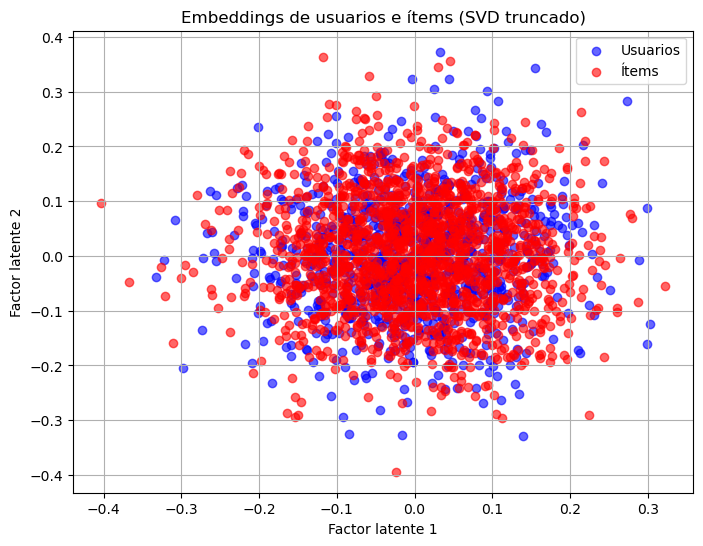

In [81]:
# Supongamos que k=2 para poder graficar
plt.figure(figsize=(8,6))

# Graficar embeddings de usuarios
plt.scatter(X_users[:,0], X_users[:,1], c='blue', alpha=0.6, label='Usuarios')

# Graficar embeddings de ítems
plt.scatter(Y_items[:,0], Y_items[:,1], c='red', alpha=0.6, label='Ítems')

plt.xlabel('Factor latente 1')
plt.ylabel('Factor latente 2')
plt.title('Embeddings de usuarios e ítems (SVD truncado)')
plt.legend()
plt.grid(True)
plt.show()

El gráfico muestra los embeddings de usuarios (azul) e ítems (rojo) en un espacio latente 2D obtenido con SVD truncado (k=2).
- Cada punto representa un usuario o ítem según sus factores latentes más importantes.
- La proximidad entre puntos indica similitud en preferencias o características latentes: usuarios cercanos tienden a tener gustos similares, y ítems cercanos tienden a ser percibidos como similares.

---

OpenAI. (2025, noviembre 6). Asistencia interactiva con ChatGPT-5 en la implementación y documentación de FunkSVD y SVD truncado en Python. OpenAI. https://www.openai.com/chat